## Finding best-fit lines with linear regression

Our prediction is given by $y_1 = X^T_1 w$, how can we find the ws?  
- One way is to find the ws that minimize the error. We define error as the difference between predicted y and the actual y.  
We can write this as
$$\sum_{i=1}^{m}(y_i-x_i^T w)^2$$

We can also write this in matrix notation as $(y-Xw)^T(y-Xw)$. If we take the derivative of this with respect to $w$, we'll get:
$$\frac{\delta((y-Xw)^T(y-Xw))^{'}}{dw} = -X^T(Y-Xw) - (Y-Xw)^{T}X = 0$$

$$\Rightarrow -X^T(Y-Xw) - X^{T}(Y-Xw)= 0 $$

$$\Rightarrow X^T(Y-Xw)=0 $$

$$\Rightarrow \hat w = (X^{T}X)^{-1}X^{T}Y $$

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def loadDataSet(filename):
    numFeat = len(open(filename).readline().split('\t'))-1
    dataMat = []
    labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [20]:
def Calcua1lateWs(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws

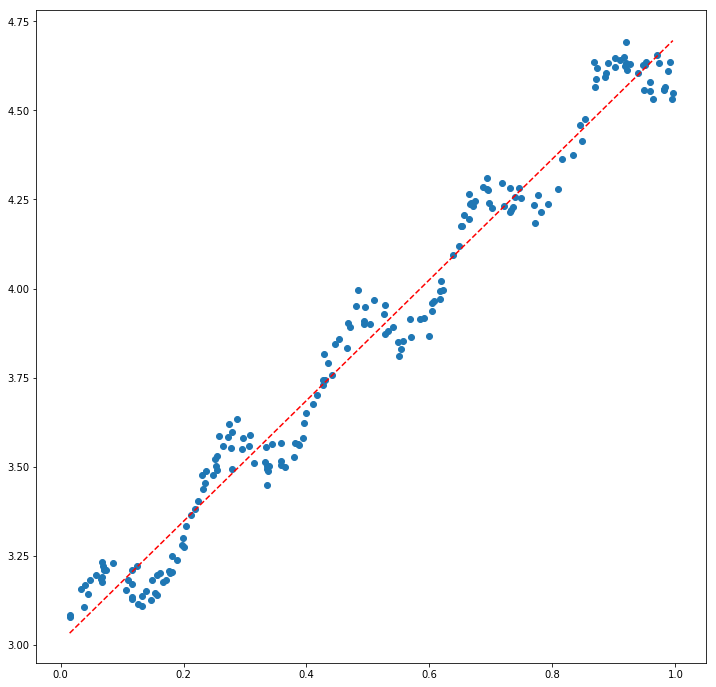

In [27]:
# linear regression test
xArr, yArr = loadDataSet('./src/ex0.txt')
ws = Calcua1lateWs(xArr, yArr)

xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat*ws

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

ax.scatter(xMat[:, 1].flatten().A[0], yMat.T[:, 0].flatten().A[0])

xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:, 1], yHat, 'r--')
plt.show()

## Locally weighted linear regression 

$$\hat w = (X^{T}WX)X^{T}W_y$$

$$w(i,i)=exp(\frac{|x^{(i)}-x|}{-2k^2})$$

In [13]:
def lwlr(testPoint, xArr, yArr, k=1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):
        diffMat = testPoint - xMat[j, :]
        weights[j, j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T*(weights*xMat)
    if np.linalg.det(xTx) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*(weights*yMat))
    return testPoint*ws

In [14]:
def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

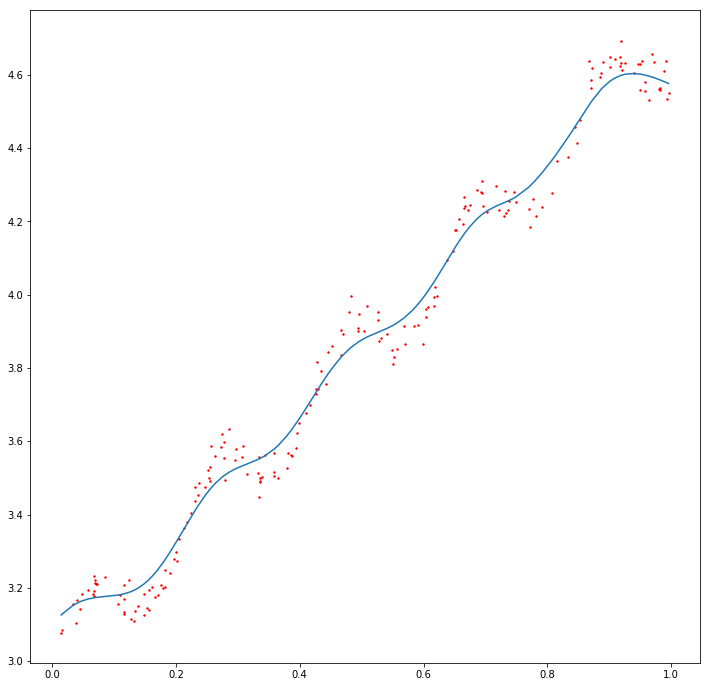

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xArr, yArr = loadDataSet('./src/ex0.txt')
yHat = lwlrTest(xArr, xArr, yArr, 0.05)

xMat = np.mat(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd][:, 0, :]

ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten().A[0], np.mat(
    yArr).T.flatten().A[0], s=2, c='red')
plt.show()

## Shrinking coefficients to understand our data
### Ridge regression 
$$\hat w = (X^{T}X+\lambda I)^{-1}X^{T}y$$

In [43]:
def ridgeRegres(xMat, yMat, lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws

In [50]:
def ridgeTest(xArr, yArr):
    # convert to matrix
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    # calculate the average value
    yMean = np.mean(yMat, axis=0)
    yMat = yMat - yMean
    xMeans = np.mean(xMat, axis=0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30
    wMat = np.zeros((numTestPts, np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, np.exp(i-10))
        wMat[i, :] = ws.T
    return wMat

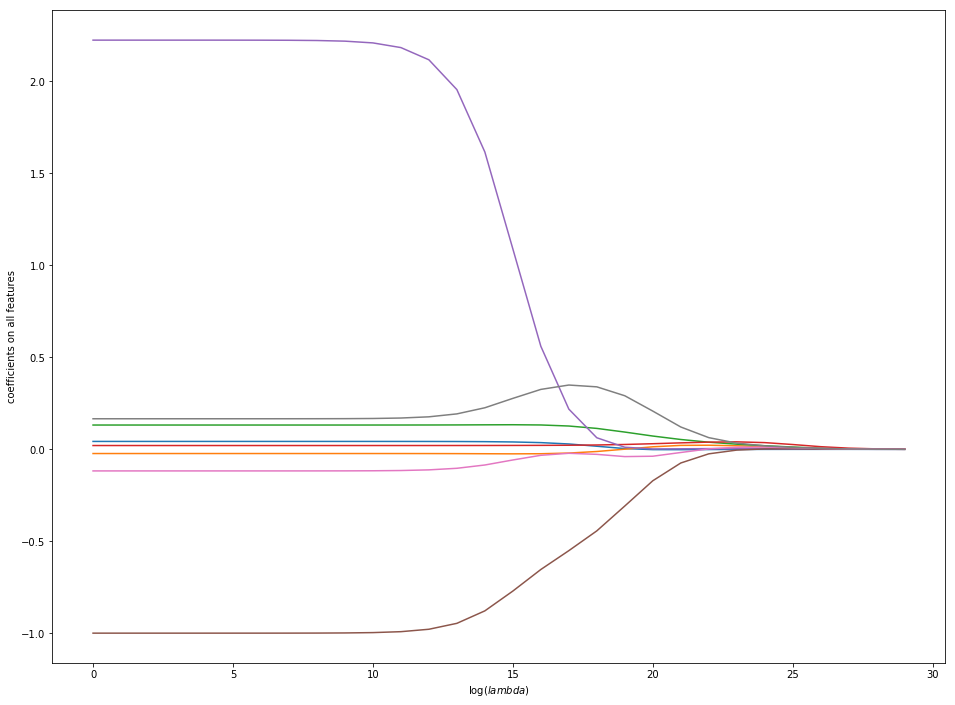

In [56]:
abX, abY = loadDataSet('./src/abalone.txt')
ridgeWeights = ridgeTest(abX, abY)
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.xlabel('$\log (lambda)$')
plt.ylabel('coefficients on all features')
plt.show()

In [58]:
def rssError(yArr, yHatArr):  # yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

In [67]:
def regularize(xMat):  # regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat, 0)  # calc mean then subtract it off
    inVar = np.var(inMat, 0)  # calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

In [80]:
def stageWise(xArr, yArr, eps=0.0, numIt=100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    yMean = np.mean(yMat, axis=0)
    yMat = yMat - yMean
    xMat = regularize(xMat)
    m, n = np.shape(xMat)
    returnMat = np.zeros((numIt, n))
    ws = np.zeros((n, 1))
    wsTest = ws.copy()
    wsMax = ws.copy
    for i in range(numIt):
        #print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i, :] = ws.T
    return returnMat

In [81]:
xArr, yArr = loadDataSet('./src/abalone.txt')
returnMat = stageWise(xArr, yArr, 0.01, 200)
print(returnMat)

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]
 [ 0.04  0.    0.09 ... -0.64  0.    0.36]
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]]


In [82]:
returnMat = stageWise(xArr,yArr,0.001,5000)
print(returnMat[:5])
print(returnMat[-5:-1])

[[0.    0.    0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.    0.003 0.    0.    0.    0.   ]
 [0.    0.    0.    0.004 0.    0.    0.    0.   ]
 [0.    0.    0.    0.005 0.    0.    0.    0.   ]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
